In [1]:
# Import required modules
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt


# Explore the data
team_flights = pd.read_csv('team_flights.csv')
fuel_prices = pd.read_csv('fuel_prices_2101.csv', index_col='date')

team_flights.head()

# Some basic data cleaning and pre-processing
team_flights['departure_datetime'] = pd.to_datetime(team_flights['departure_datetime'])
team_flights['landing_datetime']   = pd.to_datetime(team_flights['landing_datetime'])

fuel_prices.index = pd.DatetimeIndex(fuel_prices.index).to_period('D')

We're interested in the maximum number of jets that The League needs to own. Create a time-series graph that shows how many teams will be “in flight” throughout the 2102 season. Use this graphic to tell us the maximum number of teams simultaneously in flight. Store these results in variables named  **_'max_teams_in_flight'_**

In [9]:
# Outlook of the first 6 rows
team_flights.head(6)

,team_name,departure_datetime,landing_datetime,travel_distance_miles
0,Agile Antelopes,2102-04-06 21:37:00,2102-04-07 00:35:57,1491.250000
1,Agile Antelopes,2102-04-10 23:57:00,2102-04-11 01:35:40,822.222222
2,Agile Antelopes,2102-04-14 00:29:00,2102-04-14 05:02:55,2282.638889
3,Agile Antelopes,2102-04-21 03:31:00,2102-04-21 05:23:09,934.583333
4,Agile Antelopes,2102-04-24 22:23:00,2102-04-25 00:25:50,1023.611111
5,Agile Antelopes,2102-04-29 03:57:00,2102-04-29 04:22:29,212.361111


In [10]:
# Concatenating to a single pandas Series so we can find cumulative sum to obtain the number of jets flying
datetime = pd.concat([pd.DataFrame({'datetime': team_flights['departure_datetime'], 'change':1}),
                     pd.DataFrame({'datetime': team_flights['landing_datetime'], 'change': -1})])

In [11]:
datetime = datetime.sort_values('datetime').reset_index(drop=True)

In [12]:
datetime['number_in_air'] = datetime['change'].cumsum()

In [15]:
max_teams_in_flight = datetime['number_in_air'].max()
print(f"Maximum number of teams simultaneously in flight: {max_teams_in_flight}")

Maximum number of teams simultaneously in flight: 19


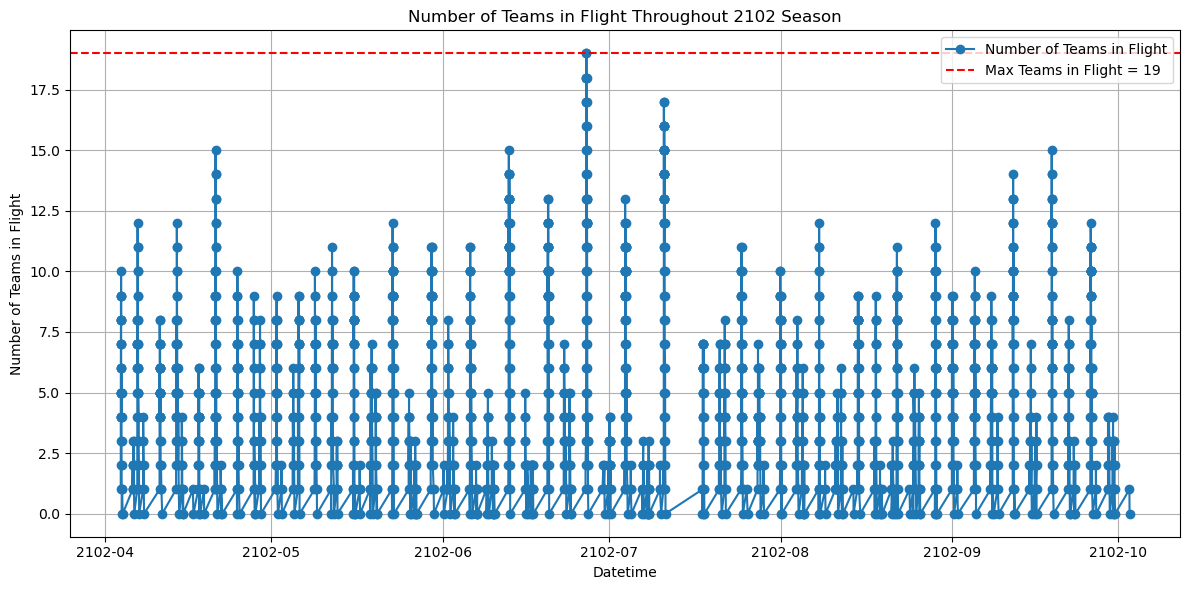

In [18]:
plt.figure(figsize=(12,6))
plt.plot(datetime['datetime'], datetime["number_in_air"], marker = 'o', label = "Number of Teams in Flight")
plt.axhline(y=max_teams_in_flight, color='r', linestyle='--', label= f'Max Teams in Flight = {max_teams_in_flight}')
plt.xlabel("Datetime")
plt.ylabel("Number of Teams in Flight")
plt.title("Number of Teams in Flight Throughout 2102 Season")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Use 2101's jet fuel prices to project jet fuel prices for 2102. Apply these projections to every flight taken by every team to determine the overall fuel spend for 2102. Store your result in a variable named **_total_fuel_spend_2102_dollars_**

In [19]:
# Fit Seasonal ARIMA model
model = SARIMAX(fuel_prices, order = (1,1,1), seasonal_order=(1,0,0,7))
model_fit = model.fit()

In [20]:
# Forecast fuel prices for 2102
forecast = model_fit.get_forecast(steps = 365)

In [21]:
# Convert to Dataframe
fuel_prices_forecast = pd.DataFrame(data={"date": forecast.summary_frame().index.to_timestamp(), 
                                         "price": forecast.predicted_mean.values})

In [22]:
team_flights['departure_date'] = team_flights["departure_datetime"].dt.date

In [23]:
fuel_prices_forecast['date'] = fuel_prices_forecast['date'].dt.date

In [24]:
fuel_prices_forecast.set_index('date', inplace=True)

In [25]:
merged_df = team_flights.join(fuel_prices_forecast, on='departure_date', how='left')

In [26]:
merged_df['fuel_cost_total'] = merged_df['price'] * merged_df['travel_distance_miles']

In [27]:
total_fuel_spend_2102_dollars = merged_df['fuel_cost_total'].sum()
total_fuel_spend_2102_dollars

1859815.1755739353